#*Import some dependencies*



In [ ]:
!pip install -U accelerate
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/IMDB-Movie-Data.csv", usecols=["Description", "Genre"])
df.head()

,Genre,Description
0,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...
1,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te..."
2,"Horror,Thriller",Three girls are kidnapped by a man with a diag...
3,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea..."
4,"Action,Adventure,Fantasy",A secret government agency recruits some of th...


In [ ]:
df.shape
df.info()

df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Genre        1000 non-null   object
 1   Description  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


0

<Axes: ylabel='Frequency'>

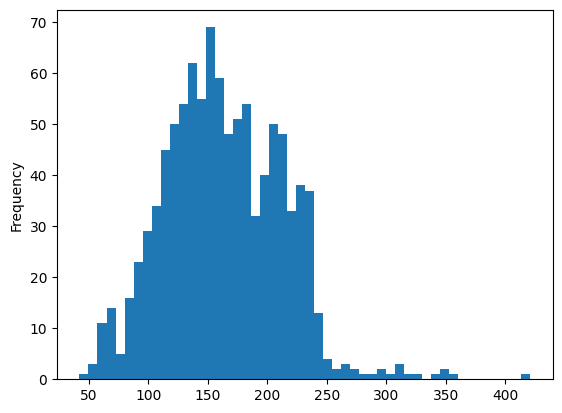

In [ ]:
df['Description'].str.len().plot.hist(bins=50)

In [ ]:
df['Genre'] = df['Genre'].str.split(',')

In [ ]:
genre_counts = [g for gen in df['Genre'] for g in gen]
pd.Series(genre_counts).value_counts()

Drama        513
Action       303
Comedy       279
Adventure    259
Thriller     195
Crime        150
Romance      141
Sci-Fi       120
Horror       119
Mystery      106
Fantasy      101
Biography     81
Family        51
Animation     49
History       29
Sport         18
Music         16
War           13
Western        7
Musical        5
Name: count, dtype: int64

## Label Encoder

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
multilabel = MultiLabelBinarizer()

labels = multilabel.fit_transform(df['Genre']).astype('float32')

texts = df['Description'].tolist()


In [ ]:
labels
texts[:5]

['A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.',
 'Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.',
 'Three girls are kidnapped by a man with a diagnosed 23 distinct personalities. They must try to escape before the apparent emergence of a frightful new 24th.',
 "In a city of humanoid animals, a hustling theater impresario's attempt to save his theater with a singing competition becomes grander than he anticipates even as its finalists' find that their lives will never be the same.",
 'A secret government agency recruits some of the most dangerous incarcerated super-villains to form a defensive task force. Their first mission: save the world from the apocalypse.']

## Model Building

In [ ]:
import torch
from transformers import DistilBertTokenizer
from transformers import AutoTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels,
                                                                    test_size=0.2, random_state=42)



In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels[0]),
                                                            problem_type="multi_label_classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
labels[0]

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0.], dtype=float32)

In [ ]:
# Lets build custom dataset
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
    }



In [ ]:
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

In [ ]:
# Multi-Label Classification Evaluation Metrics
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch


def multi_labels_metrics(predictions, labels, threshold=0.3):
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(predictions))

  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs>=threshold)] = 1
  y_true = labels

  f1 = f1_score(y_true, y_pred, average = 'macro')
  roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
  hamming = hamming_loss(y_true, y_pred)

  metrics = {
      "roc_auc": roc_auc,
      "hamming_loss": hamming,
      "f1": f1
  }

  return metrics

def compute_metrics(p:EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

  result = multi_labels_metrics(predictions=preds,
                                labels=p.label_ids)

  return result

In [ ]:
# Training Arguments
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    output_dir = './results',
    num_train_epochs=8,
    save_steps=2000,
    save_total_limit=5
)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics=compute_metrics)

In [ ]:
trainer.train()

Step,Training Loss
500,0.240200


TrainOutput(global_step=640, training_loss=0.21561754047870635, metrics={'train_runtime': 81.3588, 'train_samples_per_second': 78.664, 'train_steps_per_second': 7.866, 'total_flos': 212015874048000.0, 'train_loss': 0.21561754047870635, 'epoch': 8.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.2315693348646164,
 'eval_roc_auc': 0.6586817833629104,
 'eval_hamming_loss': 0.09875,
 'eval_f1': 0.3834260834047204,
 'eval_runtime': 0.8397,
 'eval_samples_per_second': 238.184,
 'eval_steps_per_second': 23.818,
 'epoch': 8.0}

In [ ]:
train_logs = trainer.state.log_history

# Extract training accuracy from logs
train_accuracy = [log['eval_metric'] for log in train_logs if 'eval_metric' in log and 'roc_auc' in log['eval_metric']]

# Print the training accuracy
print("Training Accuracy:", train_accuracy)

Training Accuracy: []


In [ ]:
trainer.save_model("distilbert-finetuned-imdb-multi-label")

In [ ]:
import pickle
with open("multi-label-binarizer10epochs.pkl", "wb") as f:
  pickle.dump(multilabel, f)

In [ ]:
!zip -r distilbert.zip "/content/distilbert-finetuned-imdb-multi-label"

  adding: content/distilbert-finetuned-imdb-multi-label/ (stored 0%)
  adding: content/distilbert-finetuned-imdb-multi-label/training_args.bin (deflated 51%)
  adding: content/distilbert-finetuned-imdb-multi-label/config.json (deflated 62%)
  adding: content/distilbert-finetuned-imdb-multi-label/model.safetensors (deflated 8%)


# Predictions

In [ ]:
text = "A young girl finds herself in a reform school after therapy since she was blamed for the death of a young boy. At the school she finds herself drawn to a fellow student, unaware that he is an angel, and has loved her for thousands of years."

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.2)] = 1

multilabel.classes_

multilabel.inverse_transform(preds.reshape(1,-1))

[('Adventure', 'Drama', 'Family', 'Fantasy')]

In [ ]:
preds.reshape(1,-1)

array([[0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])